# SGD vs Linear Regression 
# Primero Inflar la data de Seattle e importar herramientas🎈

1. Utilizar el data set de la "Librería de Seattle" para calcular el número de check-outs por año.
2. Implementar el algoritmo de regresión lineal en línea usando stochastic gradient descent y ajustarlo a los check-outs por año.
3. Ajustar una regresión a los check-outs por año usando el método LinearRegression de sklearn y compararlo con el resultado de paso 2.
Entregar un reporte en pdf que contenga la comparación de las dos regresiones, el código de la regresión lineal en línea y las conclusiones que hayan obtenido.

In [133]:
#Importamos muchas cosas diría lady Wooo
!python -m pip install "dask[complete]"
import pandas as pd
import numpy as np
import random
import csv
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#Este paso es el más importante, usamos DASK para no consumir RAM y hacerlo rápido
import dask
import dask.dataframe as dd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Conecto mi DRIVE donde ya está el comprimido checkouts_seattle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
!unzip drive/MyDrive/checkouts_seattle.zip

Archive:  drive/MyDrive/checkouts_seattle.zip
  inflating: Checkouts by Title FAQs.pdf  
  inflating: checkouts-by-title.csv  
  inflating: socrata_metadata.json   
CPU times: user 948 ms, sys: 121 ms, total: 1.07 s
Wall time: 1min 45s


# Sampling de 350k líneas y Tablita Checkouts x Año
# ¡Dask es mi señor! en Dask confío hehe 😎

Vemos que el CSV de Seattle tiene 7.13GB de tamaño y 35 millones de líneas (34,892,624). Por tanto, podríamos tener un muestreo k de 350,000 por ejemplo. Este muestreo sería del 1%. Posteriormente pongo esa muestra en un pandas DF

In [ ]:
#--DASK es super bueno para este tipo de trabajos porque:
# Dask, a flexible parallel computing library for Python. 
# Among many other features, Dask provides an API that emulates Pandas, 
# while implementing chunking and parallelization transparently.
start = time.time()
dask_df = dd.read_csv('/content/checkouts-by-title.csv')
end = time.time()
print("Tiempo de lectura del BIG CSV: ",(end-start),"sec")
start = time.time()
dfs = dask_df.sample(frac=0.01, replace=False, random_state=1)
end = time.time()
print("Tiempo del Sampling DASK: ",(end-start),"sec")
start = time.time()
df = dfs.compute()
end = time.time()
print("Tiempo de paso a Pandas",(end-start),"sec")

Tiempo de lectura del BIG CSV:  0.14317560195922852 sec
Tiempo del Sampling DASK:  0.008031129837036133 sec
Tiempo de paso a Pandas 179.07976365089417 sec


In [ ]:
#Genero la tablita que usaré para la regresión lineal y el SGD home-made
tablita = df.groupby(['CheckoutYear'], as_index=False).agg(CO=pd.NamedAgg(column="Checkouts", aggfunc="sum"))
tablita.rename(columns = {'CheckoutYear':'YR'}, inplace = True)
tablitasorted = tablita.sort_values(by='YR', ascending=True, ignore_index=True)
tablitasorted

,YR,CO
0,2005,34276
1,2006,74581
2,2007,71220
3,2008,82107
4,2009,87709
5,2010,90168
6,2011,83189
7,2012,74803
8,2013,94443
9,2014,94389


# Ahora la Regresión lineal vs SGD home-made
# Hacemos código y unos charts coquetos ⛪

Primero lo primero la REGRESIÓN LINEAL

In [ ]:
# Primero importamos scipy para regresión lineal
from scipy import stats

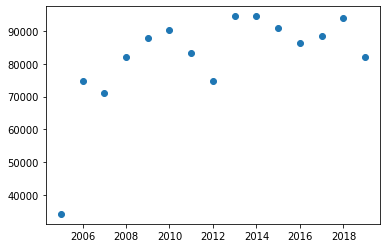

In [ ]:
#Ploteamos un poquillo los números ántes de hacer la regresión lineal con scipy
#Hacemos un SQUEEZE para quitarle 1 dimensión y dejar un array 1D
y = tablitasorted.drop(['YR'], axis=1).to_numpy().squeeze()
x = tablitasorted.drop(['CO'], axis=1).to_numpy().squeeze()
plt.scatter(x, y)
plt.show()

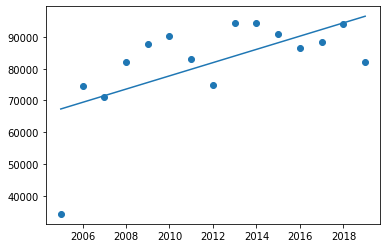

In [ ]:
#Hacemos la regresión lineal, obtenemos la R y ploteamos durísimo!!!
slope, intercept, r_lr, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

Segundo, un código SGD HECHO EN CASA (Regresión lineal en línea)

In [150]:
#Si señor, me fusilé este código de:
#https://medium.com/@nikhilparmar9/simple-sgd-implementation-in-python-for-linear-regression-on-boston-housing-data-f63fcaaecfb1
#Créditos al señor Nikhil Parmar que hizo esto en 2019
def MyCustomSGD(train_data,learning_rate,n_iter,k,divideby):
    
    # Initially we will keep our W and B as 0 as per the Training Data
    w=np.zeros(shape=(1,train_data.shape[1]-1))
    b=0
    
    cur_iter=1
    while(cur_iter<=n_iter): 

        # We will create a small training data set of size K
        temp=train_data.sample(k)
        
        # We create our X and Y from the above temp dataset
        # By the way we scale this shit first to improve the model
        y = temp.drop(['YR'], axis=1).to_numpy().squeeze()
        x = temp.drop(['CO'], axis=1).to_numpy().squeeze()
        x = scale(x)
        y = scale(y)
        
        # We keep our initial gradients as 0
        w_gradient=np.zeros(shape=(1,train_data.shape[1]-1))
        b_gradient=0
        
        for i in range(k): # Calculating gradients for point in our K sized dataset
            prediction=np.dot(w,x[i])+b
            w_gradient=w_gradient+(-2)*x[i]*(y[i]-(prediction))
            b_gradient=b_gradient+(-2)*(y[i]-(prediction))
        
        #Updating the weights(W) and Bias(b) with the above calculated Gradients
        w=w-learning_rate*(w_gradient/k)
        b=b-learning_rate*(b_gradient/k)
        
        # Incrementing the iteration value
        cur_iter=cur_iter+1
        
        #Dividing the learning rate by the specified value
        learning_rate=learning_rate/divideby
        
    return w,b #Returning the weights and Bias

Usamos nuestro modelito Home Made SGD para plotear tokio morokio

In [154]:
w,b=MyCustomSGD(tablitasorted,learning_rate=1,n_iter=100,divideby=2,k=10)

In [155]:
slope = w[0][0]
intercept = b[0][0]
print("slope is:",slope,"intercept is:",intercept)

slope is: 0.6721549875779492 intercept is: -4.9800047132944105e-15


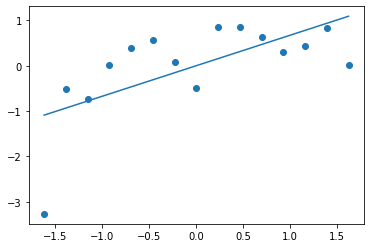

In [157]:
#Escalamos x,y para plotear los resultados nuevamente
x=scale(x)
y=scale(y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

# Comparar las R y sacar conclusiones

In [163]:
#Una pequeña función para predecir las Y dado el modelo SGD
def predict(x,w,b):
    y_pred=[]
    for i in range(len(x)):
        y=np.dot(w,x[i])+b
        y_pred.append(y)
    return np.array(y_pred)

In [166]:
y_pred_customsgd=predict(x,slope,intercept)
print('Mean Squared Error for HOME-MADE SGD :',mean_squared_error(y, y_pred_customsgd))
print('Mean Squared Error for Scipy R^2 :',r_lr)
print('Make your conclusions b*tch!')

Mean Squared Error for HOME-MADE SGD : 0.6214921728112589
Mean Squared Error for Scipy R^2 : 0.6176404027786561
Make your conclusions b*tch!
